In [1]:
# !pip install -q bitsandbytes accelerate loralib datasets
# !pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [2]:
import os
import torch
import json
import random
import numpy as np
import json
import datasets as ds
import pandas as pd
import matplotlib.pyplot as plt

from transformers import OPTForCausalLM, AutoTokenizer, AutoConfig
from datasets import load_dataset, Dataset, concatenate_datasets
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR
from peft import LoraConfig, get_peft_model
from random import randint, sample

from data_utils import (
    load_glue_datasets,
    load_hans_dataset,
    load_paws_qqp_dataset,
    get_dataset,
)
from context_utils import (
    create_few_shot_context, 
    select_demonstrations, 
    create_train_batch_token,
    create_validation_batch_token,
)
from training_utils import (
    set_seed,
    CastOutputToFloat,
    get_model,
    plot_losses,
    train,
    predict
)

In [3]:
# ds.logging.set_verbosity(40)

In [4]:
# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     ds.logging.set_verbosity(40)

# def print_trainable_parameters(model):
#     trainable_params = 0
#     all_param = 0
#     for _, param in model.named_parameters():
#         all_param += param.numel()
#         if param.requires_grad:
#             trainable_params += param.numel()
#     print(
#         f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
#     )

# class CastOutputToFloat(torch.nn.Sequential):
#   def forward(self, x): return super().forward(x).to(torch.float32)

# def get_model(model_name):
#     model_name = "facebook/" + model_name
#     config = AutoConfig.from_pretrained(model_name)
#     config.hidden_dropout_prob = 0.1
#     tokenizer = AutoTokenizer.from_pretrained(model_name) # tokenizer
#     teacher_model = OPTForCausalLM.from_pretrained(model_name) # teacher model
#     student_model = OPTForCausalLM.from_pretrained(model_name, config=config) # student model

#     for param in student_model.parameters():
#         param.requires_grad = False
#         if param.ndim == 1:
#             param.data = param.data.to(torch.float32)
    
#     student_model.gradient_checkpointing_enable()
#     student_model.enable_input_require_grads()
#     student_model.lm_head = CastOutputToFloat(student_model.lm_head)

#     config = LoraConfig(
#         r=16,
#         lora_alpha=32,
#         lora_dropout=0.05,
#         bias="none",
#         task_type="CAUSAL_LM"
#     )
    
#     student_model = get_peft_model(student_model, config)
#     return tokenizer, student_model, teacher_model

# def get_dataset(data_set_used):
#     datasets, labels, num_labels = load_glue_datasets(data_set_used)
    
#     if data_set_used in ['mnli', 'rte', 'hans']:
#         teacher_prompt = 'Think logically. Are the following sentences examples of entailment, yes or no?'
#         student_prompt = 'Are the following sentences examples of entailment, yes or no?'
#     elif data_set_used in ['qqp', 'paws-qqp']:
#         teacher_prompt = 'Think logically. Are the following sentences duplicates or paraphrases of each other, yes or no?'
#         student_prompt = 'Are the following sentences duplicates or paraphrases of each other, yes or no?'

#     return datasets, labels, num_labels, teacher_prompt, student_prompt
    
# # Assuming `losses` is the list of epoch losses returned from the `train` function
# def plot_losses(losses):
#     plt.figure(figsize=(10, 5))
#     plt.plot(losses, marker='o', linestyle='-', color='b')
#     plt.title('Training Loss Per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Average Loss')
#     plt.grid(True)
#     plt.show()

# def train(teacher_model, student_model, data, epochs=10, batch_size=32, device='cpu'):
#     student_model.to(device)
#     teacher_model.to(device)
#     print(id(student_model))
#     print(id(teacher_model))
    
#     student_model.train()
#     optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5, weight_decay=0.000001 )
#     epoch_losses = []

#     if (len(data) % batch_size != 0):
#         num_batches = (len(data) // batch_size) + 1
#     else:
#         num_batches  = len(data) // batch_size

#     num_datapoints = len(data)
#     total_steps = num_batches * epochs
#     warmup_ratio = int(0.1 * total_steps) 
    
#     def lr_schedular(current_step: int):
#         if current_step < warmup_ratio:
#             return float(current_step) / float(max(1,warmup_ratio))
#         return 1.
    
#     scheduler = LambdaLR(optimizer, lr_schedular)

#     for epoch in range(epochs):
#         total_loss = 0
#         samples_left = num_datapoints
        
#         for i in range(num_batches):
#             batch_loss = 0
#             if ((samples_left - batch_size) >= 0):
#                 samples_used = batch_size
#                 samples_left -= batch_size
#             else:
#                 samples_used = samples_left
#                 samples_left = 0
#             for j in range(samples_used):
#                 index = i * batch_size + j
                
#                 teacher_inputs = data[index]['context'].to(device)
#                 student_inputs = data[index]['query'].to(device)
                                
#                 teacher_outputs = teacher_model.generate(
#                     **teacher_inputs,
#                     max_length=teacher_inputs['input_ids'].shape[-1] + 1,
#                     output_scores=True,
#                     return_dict_in_generate=True
#                 )
#                 teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)
                
#                 student_logits = student_model(**student_inputs).logits
#                 student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)
                
#                 kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
                
#                 optimizer.zero_grad()
#                 kl_divergence.backward()
#                 optimizer.step()

#                 batch_loss += kl_divergence.item()

#             # Average loss for the batch
#             batch_loss /= batch_size
#             total_loss += batch_loss
#             scheduler.step()
#             #print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


#         # Average loss for the epoch
#         epoch_loss = total_loss / num_batches
#         epoch_losses.append(epoch_loss)

#         print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")
        
#     print(f"Total loss : {total_loss/epochs}")
#     plot_losses(epoch_losses)
#     # torch.save(student_model, './models/student.pth')

# def predict(model, source, target=None, device='cpu'):
#     predict = []
#     for token in source:
#         output = model.generate(**token, max_length=token['input_ids'].shape[-1] + 1).to(device)
#         decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
#         predicted_label = decoded_output.split("Label:")[-1].strip().split('.')[0].strip()
#         predict.append(predicted_label)
        
#     return predict


In [29]:
def run_job(dataset_used, model_name, epochs, val_len, train_len, context_len, seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    datasets, labels, num_labels, teacher_prompt, student_prompt = get_dataset(data_set_used)
    
    set_seed(seed)
    print('starting run: {}'.format(seed))
    print('loading model')
    tokenizer, student_model, teacher_model = get_model(model_name)
    print("finished loading model")

    print("loading data")
    train_data_tokens, train_data_strings, indices, context_indices = create_train_batch_token(
        data_set_used, 
        datasets, 
        teacher_description = teacher_prompt, 
        student_description = student_prompt, 
        tokenizer=tokenizer, 
        seed=seed, 
        device=device,
        num_shots = context_len,
        num_train_samps=train_len,
    )
    print("finished loading data")

    print("training model")
    train(teacher_model, student_model, train_data_tokens, epochs = epochs, device=device)
    print("finished training model")

    print("predicting on validation set")
    student_prompt_tokens, student_prompt_strings, val_indices, val_labels = create_validation_batch_token(
        data_set_used, datasets, prompt_descr=student_prompt ,tokenizer=tokenizer, device=device, limit=100
    )
    prediction = predict(student_model, student_prompt_tokens, tokenizer = tokenizer, device=device)  
    print("finished predicting on validation set")

    accuracy = accuracy_score(prediction,val_labels)
    print("finished run {}".format(seed))
    print("final result",accuracy)

    if not os.path.exists('output'):
        os.makedirs('output')
        
    meta_data_file_name = f'{dataset_used}_{model_name}_{seed}_{epochs}_{val_len}_{train_len}_{context_len}.json'
    metadata_loc = os.path.join('output',meta_data_file_name)
    metadata = {
        'accuracy': accuracy,
        'query_indices': indices,
        'context_indices': context_indices.tolist(),
        'validation_indices': val_indices.tolist(),
        'model_name': model_name,
        'dataset_used': dataset_used,
        'seed': seed,
        'epochs': epochs,
        'val_len': val_len,
        'train_len': train_len,
        'context_len': context_len
    }
    
    with open(metadata_loc, 'w') as f:
        json.dump(metadata, f)

    return None
        

starting run: 0
loading model
finished loading model
loading data
finished loading data
training model
Epoch 1, Total Loss: 2.704346111160703
Total loss : 10.817384444642812


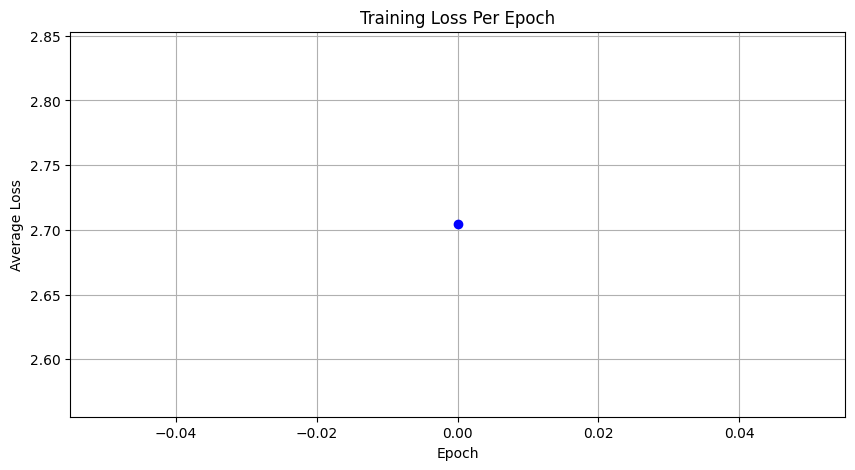

finished training model
predicting on validation set


C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


finished predicting on validation set
finished run 0
final result 0.57


In [30]:
runs = 1
data_set_used = 'mnli'
model_name = "opt-125m"
epochs = 1
val_len = 128
train_len = 128
context_len = 16

for seed in range(runs):
    run_job(data_set_used,model_name,epochs,val_len, train_len, context_len, seed)
